In [64]:
import cv2
import json
import os
import time
from PIL import Image
from IPython.display import display
import numpy as np
from random import randint
from itertools import groupby

In [112]:
with open("labels.json") as json_file:
    labels = json.loads(json_file.read())["labels"]
for label in labels
print(labels)

[{'name': 'gate', 'count': 1}, {'name': 'red_flare', 'count': 1}, {'name': 'yellow_flare', 'count': 1}, {'name': 'mat', 'count': 1}, {'name': 'red_bowl', 'count': 3}, {'name': 'blue_bowl', 'count': 1}]


In [3]:
weightsPath = os.path.join("frozen_inference_graph.pb")
print(weightsPath)
configPath = os.path.join("opencv_graph.pbtxt")
print(configPath)

frozen_inference_graph.pb
opencv_graph.pbtxt


In [4]:
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] took 0.154482 seconds
[INFO] boxes shape: (1, 1, 100, 7)


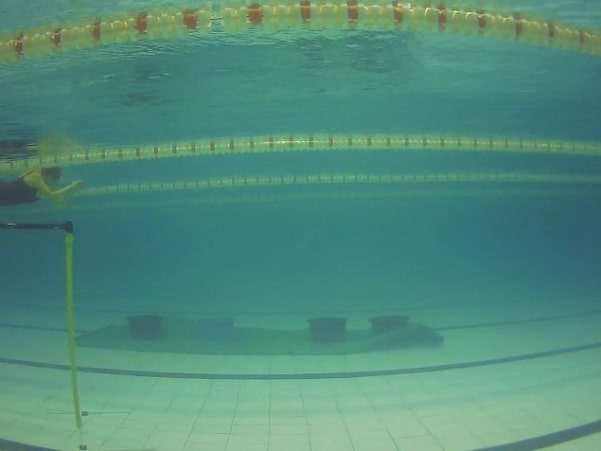

In [117]:
img = cv2.imread("test_images/1.jpg")
rows = img.shape[0]
cols = img.shape[1]
net.setInput(cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False))
start = time.time()
cvOut = net.forward()
end = time.time()
# show timing information and volume information on NET
print("[INFO] took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(cvOut.shape))
display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)))

In [189]:
# loop over the number of detected objects
objects = []
for i in range(0, cvOut.shape[2]):
    object_ = {}
    # extract the class ID of the detection along with the confidence
    # (i.e., probability) associated with the prediction
    classID = int(cvOut[0, 0, i, 1])
    confidence = cvOut[0, 0, i, 2]
 
    # filter out weak predictions by ensuring the detected probability
    # is greater than the minimum probability
    if confidence > 0.3:
        object_name = labels[classID-1]["name"]
        object_["name"] = object_name
        object_["confidence"] = confidence
        # clone our original image so we can draw on it
        # scale the bounding box coordinates back relative to the
        # size of the image and then compute the width and the height
        # of the bounding box
        box = cvOut[0, 0, i, 3:7] * np.array([cols, rows, cols, rows])
        object_["box"] = box.astype("int")
        objects.append(object_)

In [190]:
[(k, list(g)) for k,g in groupby(sorted(objects, key=lambda label: label['name']), lambda label: label['name'])]

[('blue_bowl',
  [{'name': 'blue_bowl',
    'confidence': 0.6544232,
    'box': array([182, 311, 231, 342])}]),
 ('gate',
  [{'name': 'gate',
    'confidence': 0.96829414,
    'box': array([ -1, 218,  83, 386])}]),
 ('mat',
  [{'name': 'mat',
    'confidence': 0.6513246,
    'box': array([ 54, 307, 472, 359])}]),
 ('red_bowl',
  [{'name': 'red_bowl',
    'confidence': 0.9964354,
    'box': array([128, 312, 166, 340])},
   {'name': 'red_bowl',
    'confidence': 0.9665558,
    'box': array([301, 311, 353, 343])},
   {'name': 'red_bowl',
    'confidence': 0.4120892,
    'box': array([368, 313, 412, 342])}])]

In [191]:
groups = [(k, list(g)) for k,g in groupby(sorted(objects, key=lambda label: label['name']), lambda label: label['name'])]
objects = []
for group in groups:
    object_count_from_json = list(filter(lambda label: label['name'] == group[0], labels))[0]["count"]
    del group[1][object_count_from_json:] 
    # for index, dnn_object in enumerate(group[1]):
    #     if dnn_object["confidence"] < 0.5:
    #         del group[1][index]
    objects += group[1]
objects

[{'name': 'blue_bowl',
  'confidence': 0.6544232,
  'box': array([182, 311, 231, 342])},
 {'name': 'gate',
  'confidence': 0.96829414,
  'box': array([ -1, 218,  83, 386])},
 {'name': 'mat', 'confidence': 0.6513246, 'box': array([ 54, 307, 472, 359])},
 {'name': 'red_bowl',
  'confidence': 0.9964354,
  'box': array([128, 312, 166, 340])},
 {'name': 'red_bowl',
  'confidence': 0.9665558,
  'box': array([301, 311, 353, 343])},
 {'name': 'red_bowl',
  'confidence': 0.4120892,
  'box': array([368, 313, 412, 342])}]

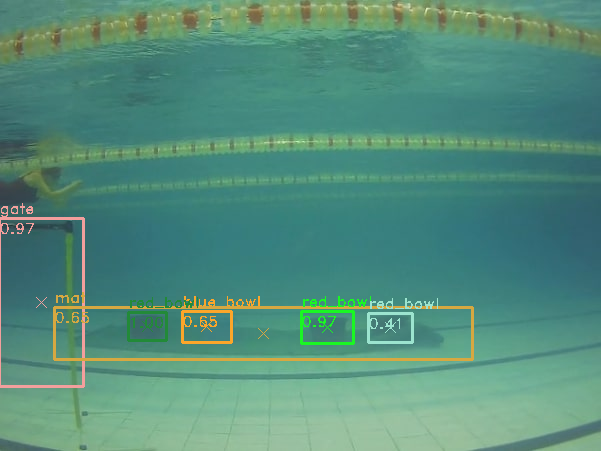

6

In [192]:
clone = img.copy()
for dnn_object in objects:
    (startX, startY, endX, endY) = dnn_object["box"]
    x_center = int(startX + (endX - startX)/2)
    y_center = int(startY + (endY - startY)/2)

    color = (randint(0, 255),randint(0, 255), randint(0, 255))

    cv2.rectangle(clone, (startX, startY), (endX, endY), color, thickness=2)  
    cv2.line(clone, (x_center - 5, y_center - 5), (x_center + 5, y_center + 5), color, thickness=1) 
    cv2.line(clone, (x_center + 5, y_center - 5), (x_center - 5, y_center + 5), color, thickness=1)    

    # draw the predicted label and associated probability of the
    # instance segmentation on the image
    text1 = "{}".format(dnn_object["name"])
    cv2.putText(clone, text1, (startX, startY - 5),cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
    text2 = "{:.2f}".format(dnn_object["confidence"])
    cv2.putText(clone, text2, (startX, startY + 15),cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
display(Image.fromarray(cv2.cvtColor(clone, cv2.COLOR_RGB2BGR)))
len(objects)

In [151]:
list(filter(lambda label: label['name'] == group[0], labels))

[{'name': 'blue_bowl', 'count': 1}]